In [2]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

**Multiclass Classification**

In the binary classification setting, models like Logistic Regression, Decision Trees and Random Forests are all suitable to being trained to distinguish between two classes, often labeled as "positive" and "negative", or 1 and 0. This is achieved by constructing decision boundaries that partition data into regions corresponding to each class. However, many models extend naturally to the multi-class classification aswell. Of those we've learned so far, both Decision Trees and Random Forest does (but not Logistic Regression). 

In multiclass classification, the goal is to classify instances into one of multiple classes, where each instance can belong to only one class. The extension to multiclass is simple:

At the terminal nodes of each decision tree, we use the training data to find the corresponding probability of the occurance of each class. A new unseen instance is then predicted to be the class which has the highest probability of occuring, according to the training data. For the multiclass setting, this works precisely the same, we just look for the highest probable class amongst several classes, instead of just two.

Random Forest is just the combination of many trees, so it works exactly as above. We just now take the majority voted class from many tree's instead.

**Objective and goal for this lab**

We will showcase how to conduct multiclass classifcation on some dummy data. 

Simultaneously, we will also an example on how to correctly work with train/validation/test splits in practice to evaluate a given model.

*Note*: what we won't focus on here are details such as data EDA or data pre-processing / feature engineering. We will simply state at what stage they apply. 

---

**Let's generate and plot some synthetic data to work with**

In [3]:
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.datasets import make_blobs

# Generate synthetic multiclass data with make_blobs
n_samples = 2000
n_features = 3
n_classes = 4  # Number of classes
random_state = 4

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, random_state=random_state, cluster_std=2)

data_dict = {'x': X[:,0], 'y': X[:,1], 'z': X[:,2], 'class': y}
data_df = pd.DataFrame(data_dict)

df = px.data.iris()
fig = px.scatter_3d(data_df, x='x', y='y', z='z', color='class')
fig.show()

---

**EDA, Data pre-processing, preliminary feature engineering**

Once we have the data loaded, we dive deep into it. This is where. We can also do needed pre-processing and some informed feature engineering choices here.

**Split the data**

Once the data is ready, we split it to a train and test split.

*Note*: Follow closely how we use these two sets during the analysis below. We will **not** use the test split for anything else than a final assessement of our models.

In [4]:
# split the data as per usual

test_size = 0.2


X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

We will be using X_train_val and y_train_val to find the best hyperparameters for our model using e.g., GridSearchVC.

---

**Hyperparameter tune a Decision Tree (multiclass) classifier**

In [5]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree_classifier = DecisionTreeClassifier(random_state=42)

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=tree_classifier, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy')

# Perform GridSearchCV on the training data
grid_search.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

Now we can print the results from the gridsearch

In [6]:
# Get all the hyperparameters and their corresponding accuracy
results = grid_search.cv_results_

# Print out hyperparameters and accuracy for all the fitted models
for i in range(len(results['params'])):
    print("Model:", i+1)
    print("Hyperparameters:", results['params'][i])
    print("Mean validation accuracy:", np.round(results['mean_test_score'][i],4))
    print()

Model: 1
Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean validation accuracy: 0.9344

Model: 2
Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Mean validation accuracy: 0.9456

Model: 3
Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Mean validation accuracy: 0.945

Model: 4
Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean validation accuracy: 0.9419

Model: 5
Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Mean validation accuracy: 0.9388

Model: 6
Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Mean validation accuracy: 0.9444

Model: 7
Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 

We can also straight up get the best performing model hyperparameters alongside its score, directly

In [7]:
# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best accuracy:", np.round(best_score,4))

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy: 0.9556


---

In this section, you can repeat the hyperparameter search above for *any* other suitable model. For example, RandomForest.

---

**Further model analysis**

Now, finding optimal hyperparameters for a given model is great. But, we naturally want to do further analysis on said models - in order to really assess their performance. To do this, we abandon the gridsearch for now (since we've already found our hyperparameters) 

1. do a manual split of X_train_val to X_train and X_val
2. retrain respective model, with the hyperparameters we've identifier, on X_train, y_train
3. evaluate and assess performance on X_val, y_val

**Note**: We do NOT involve X_test, y_test at this point

In [8]:
validation_size = 0.33

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=validation_size, random_state=41)

In [9]:
# Create another Decision Tree classifier, with the optimal hyperparameters found via grid search
tree_clf = DecisionTreeClassifier(criterion = 'gini', 
                                  max_depth = 10, 
                                  min_samples_leaf = 1, 
                                  min_samples_split = 2)

# Train the classifier on the training data
tree_clf.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = tree_clf.predict(X_val)

Once we have our predictions on the validation set, we can do conduct as much and as deep *error analysis* we want. We will speak more about error analysis in an upcoming lecture.

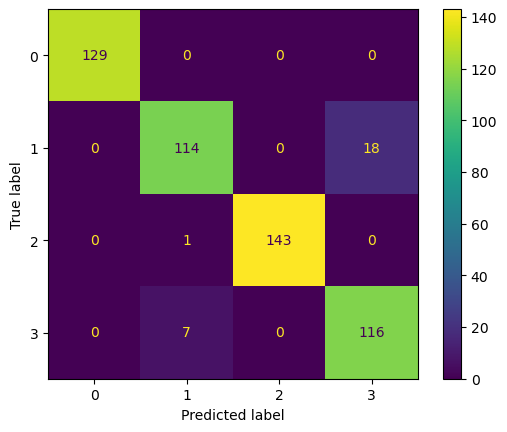

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true=y_val, y_pred=y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2, 3])

cm_display.plot()
plt.show() 

Above is the confusion matrix for the multiclass classification case.

In [11]:
from sklearn.metrics import classification_report

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy, end='\n\n')

# Generate and print classification report
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.9507575757575758

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       129
           1       0.93      0.86      0.90       132
           2       1.00      0.99      1.00       144
           3       0.87      0.94      0.90       123

    accuracy                           0.95       528
   macro avg       0.95      0.95      0.95       528
weighted avg       0.95      0.95      0.95       528



A classification_report provides relevant measures, for all classes. We've talked about precision and recall before. 

f1-score is a middle-ground/mean between  precision and recall, and you can read more about it [here](https://medium.com/@nirajan.acharya666/understanding-precision-recall-f1-score-and-support-in-machine-learning-evaluation-7ec935e8512e).

The support is simply the amount of existing class instances. For example, in our validation set, we have 129 instances of class 0.

Using the resulting analysis here, we might want to go back to step 1 and do some feature engineering.

**We will learn more about error analysis, and how to further interpret these results & solve them, in an upcoming lecture** 

---

**Final report**

Ok, assume now that you've done an exhaustive search for the best features and the best model + hyperparamaters for this problem. 

It's now time to do a final performance assessement, and get the numbers that you will report.

This is where the test set finally comes in.

In [12]:
# begin by training the model(s) with the best hyperparameters you've identified

In [13]:
tree_clf = DecisionTreeClassifier(criterion = 'gini', 
                                  max_depth = 10, 
                                  min_samples_leaf = 1, 
                                  min_samples_split = 2)

# rf_clf = RandomForestClassifier(...)

# any_other_clf = ...

Now we train those model(s) on the *whole* train and validation split (which we created in the very first step)

In [14]:
tree_clf.fit(X_train_val, y_train_val)

#rf_clf.fit(X_train_val, y_train_val)

#any_other_clf(X_train_val, y_train_val)

DecisionTreeClassifier(max_depth=10)

Predict & evaluate the models above on the **test set**

In [15]:
y_pred_tree_clf = tree_clf.predict(X_test)

#rf_clf_y_pred = ...

#any_other_clf_y_pred = ..

Having the predictions on the X_test, we can calculate all the measures that are required/asked for

In [16]:
tree_accuracy = accuracy_score(y_test, y_pred_tree_clf)
print("Accuracy:", accuracy, end='\n\n')

tree_report = classification_report(y_test, y_pred_tree_clf)
print("Classification Report:\n", tree_report)

Accuracy: 0.9507575757575758

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       0.86      0.93      0.90        87
           2       1.00      1.00      1.00        91
           3       0.94      0.89      0.92       116

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



**These** are the numbers you will finally report as the assessed performance. 

You fetch one set of these numbers for *each* of the models above. Here, we only have the numbers for the best decision tree.

**IMPORTANT**: at this point, you can NOT go back and hypertune or change anything else. The evaluation on the test set should be the **last** thing you do.

---

## Challenges

**Task 1**

Make sure to completely understand the whole process we've laid out above.

**Task 2**

Now apply this methodology to the Iris dataset, which can be found [here](https://www.kaggle.com/datasets/arshid/iris-flower-dataset?resource=download). It's a dataset suitable for multiclass classifcation.

When working on it, don't skip the EDA, pre-procecessing and feature engineering steps.

Find the best performing hyperparameters for Decision Tree, Random Forest and KNN, and make a performance report on the test set.

In [17]:
df = pd.read_csv("../data/IRIS.csv")
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.50000

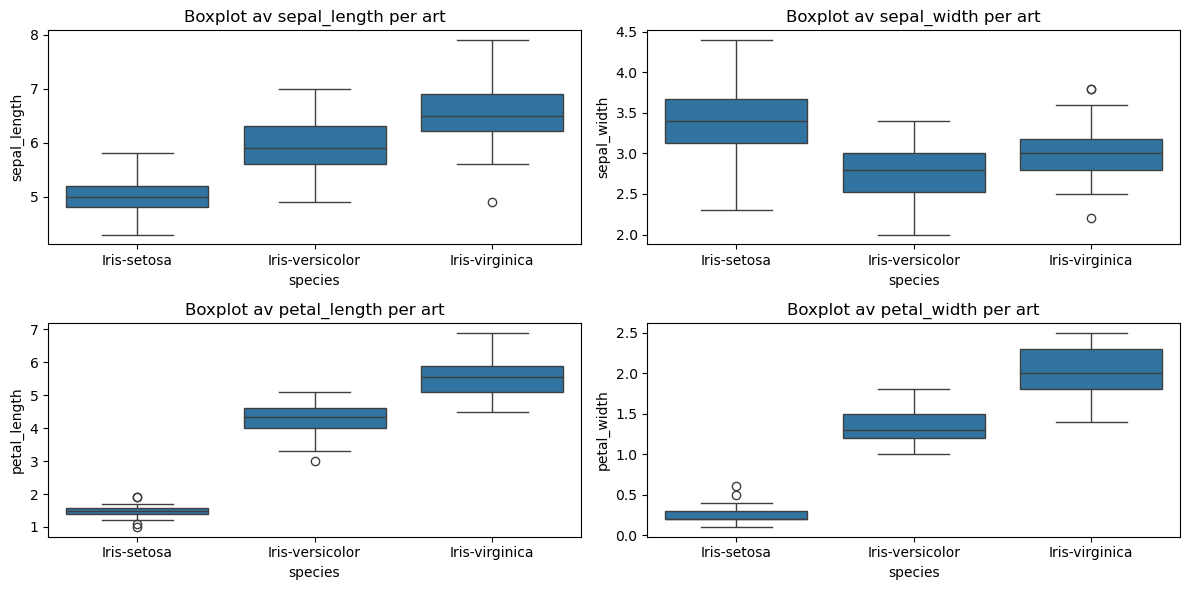

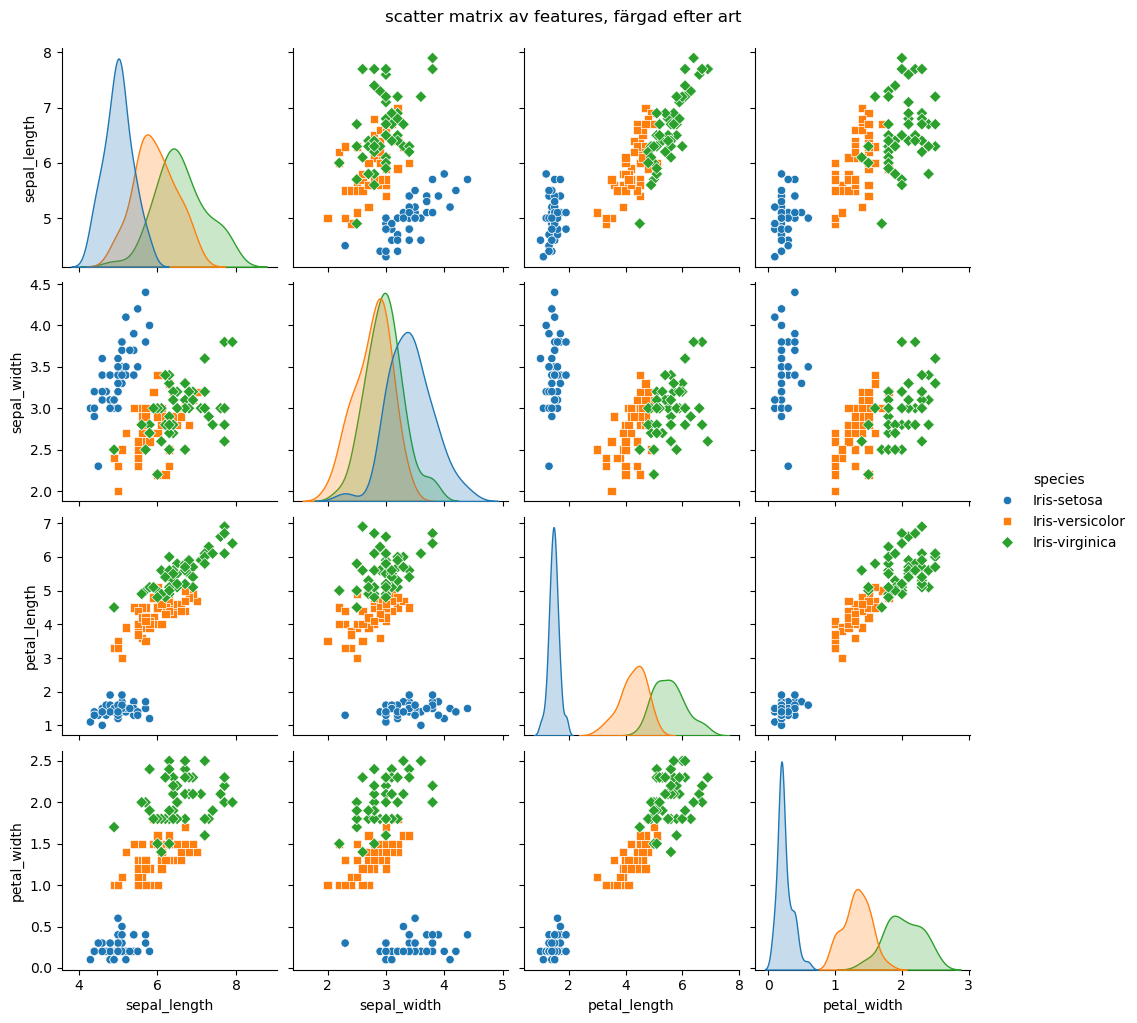

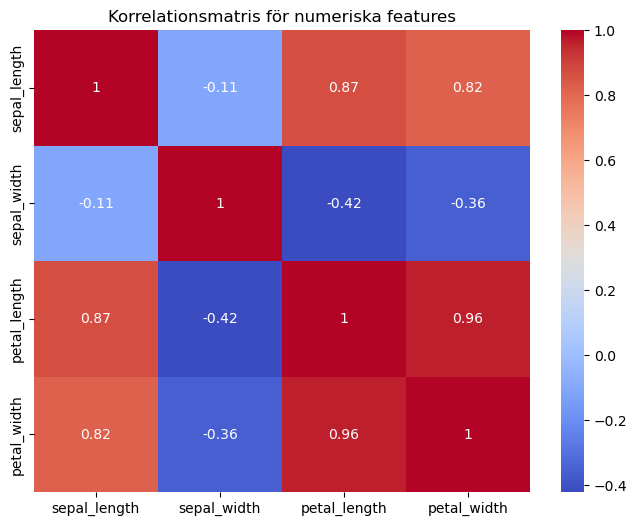

In [18]:
import seaborn as sns
plt.figure(figsize=(12,6))
for i, column in enumerate(df.columns[:-1]):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x="species", y=column, data=df)
    plt.title(f"Boxplot av {column} per art")
plt.tight_layout()
plt.show()

sns.pairplot(df, hue="species", markers=["o", "s", "D"])
plt.suptitle("scatter matrix av features, färgad efter art", y=1.02)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(df.drop("species", axis=1).corr(), annot=True, cmap="coolwarm")
plt.title("Korrelationsmatris för numeriska features")
plt.show()

In [19]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
df["species"] = label_encoder.fit_transform(df["species"])


In [20]:
df["sepal_area"] = df["sepal_length"] * df["sepal_width"]
df["petal_area"] = df["petal_length"] * df["petal_width"]


In [23]:
X = df.drop("species", axis=1)
y = df["species"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

dt_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3],
    "splitter": ["best", "random"]
}

dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=3)
dt_grid.fit(X_train, y_train)

rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [2, 5, 7, None],
    "min_samples_split": [2, 5],
    "max_features": ["sqrt", "log2"]
}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=3)
rf_grid.fit(X_train, y_train)

knn_params = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3)
knn_grid.fit(X_train_scaled, y_train)



GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']})

Decision Tree Best Params: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'splitter': 'random'}
Random Forest Best Params: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
KNN Best Params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}

=== Decision Tree ===
Accuracy: 0.9666666666666667
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.92      0.96        13
           2       0.89      1.00      0.94         8

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


=== Random Forest ===
Accuracy: 0.9666666666666667
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.92      0.96        

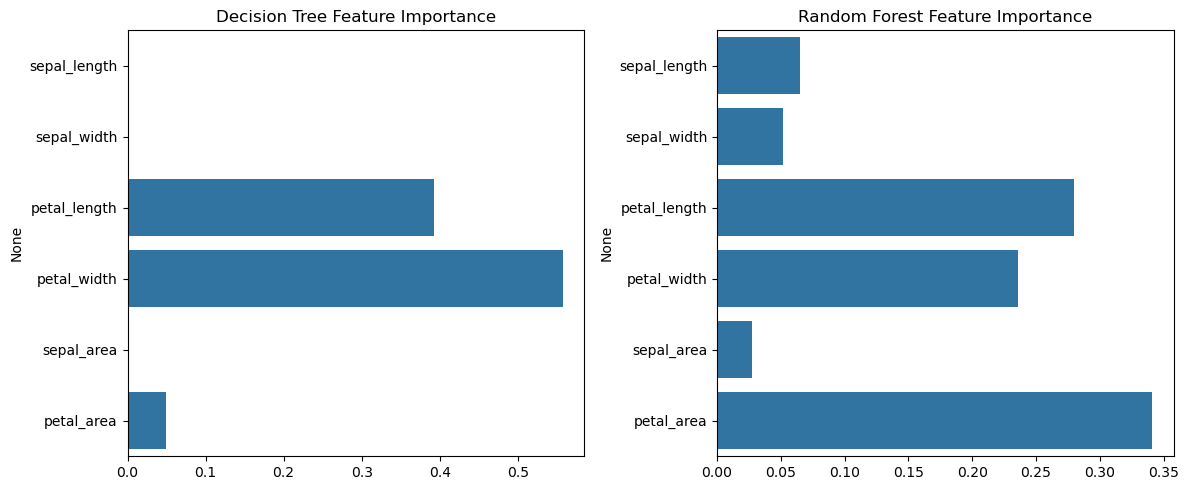

In [24]:

print("Decision Tree Best Params:", dt_grid.best_params_)
print("Random Forest Best Params:", rf_grid.best_params_)
print("KNN Best Params:", knn_grid.best_params_)

models = {
    "Decision Tree": dt_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "KNN": knn_grid.best_estimator_
}

results = []
for name, model in models.items():
    if name == "KNN":
        X_val_used = X_val_scaled
    else:
        X_val_used = X_val
        
    y_pred = model.predict(X_val_used)
    acc = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Classification Report": report
    })
    
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print("Classification Report:\n", report)

print("\n=== Final Test Evaluation ===")
for name, model in models.items():
    if name == 'KNN':
        X_test_used = X_test_scaled
    else:
        X_test_used = X_test
        
    y_pred = model.predict(X_test_used)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"{name} Test Accuracy: {acc:.4f}")
    print(f"Test Classification Report:\n{report}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=dt_grid.best_estimator_.feature_importances_, y=X.columns)
plt.title("Decision Tree Feature Importance")
plt.subplot(1, 2, 2)
sns.barplot(x=rf_grid.best_estimator_.feature_importances_, y=X.columns)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [26]:
tree_clf = DecisionTreeClassifier(criterion = "gini", 
                                  max_depth = 4, 
                                  min_samples_leaf = 2, 
                                  splitter=  "random")

tree_clf.fit(X_train_val, y_train_val)
y_pred_tree_clf = tree_clf.predict(X_test)

tree_accuracy = accuracy_score(y_test, y_pred_tree_clf)
print("Accuracy:", accuracy, end='\n\n')

tree_report = classification_report(y_test, y_pred_tree_clf)
print("Classification Report:\n", tree_report)

Accuracy: 0.9507575757575758

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

